In [2]:
import atm_coeffs as ac
import resp_delta as rd
import irrad_func as ir

In [3]:
import h5py
import numpy as np
from scipy import interpolate as inp
from scipy.integrate import quad as integrate
from scipy.special import legendre, lpmv, sph_harm
from scipy.optimize import fsolve
from random import random as rand
import inspect

from PyAstronomy import pyasl

import f90nml as nml
from astropy.io import ascii
from shutil import copyfile

import matplotlib.pyplot as plt

%matplotlib inline
#%matplotlib notebook

### Read Gyre output

In [4]:
## Class definition

class resp_coeffs:
    
    def __init__ (self, response_file):
        
        self.data = self.read_response(response_file)
        
        # Sanity check
        
        if len(self.data) == 0:
            raise Exception('Empty response file')
        if not isinstance(self.data, dict):
            raise Exception('Response file type error')
            
        # Setup axes
        
        n_l = self.data['l_max']
        n_m = 2*n_l
        n_k = self.data['k_max']
        
        self.R_lmk = np.empty([n_l+1, n_m+1, n_k+1], dtype=complex)
        self.T_lmk = np.empty([n_l+1, n_m+1, n_k+1], dtype=complex)
        self.G_lmk = np.empty([n_l+1, n_m+1, n_k+1], dtype=complex)
        
        for l in range(2, n_l+1):
            for m in range(-l, l+1):
                for k in range(0, n_k+1):
                    
                    i_l = l
                    i_m = m + n_l
                    i_k = k

                    self.R_lmk[i_l,i_m,i_k] = self.find_Delta_R(i_l,i_m,i_k)
                    self.T_lmk[i_l,i_m,i_k] = self.find_Delta_T(i_l,i_m,i_k)
                    self.G_lmk[i_l,i_m,i_k] = self.find_Delta_G(i_l,i_m,i_k, m,k)
        
        
    def read_response(self, filename):
    
    # Read data from gyre_response
    
        f = h5py.File(filename, 'r')
        
        xi_r_ref_re = f['xi_r']['re'][...]
        xi_r_ref_im = f['xi_r']['im'][...]
        
        lag_L_ref_re = f['lag_L']['re'][...]
        lag_L_ref_im = f['lag_L']['im'][...]
        
        k_max = f.attrs['k_max']
        l_max = f.attrs['l_max']
        
        Omega_rot = f.attrs['Omega_rot']
        Omega_orb = f.attrs['Omega_orb']
        
        #q = f.attrs['q']
        #e = f.attrs['e']
        
        f.close()
        
        return {'xi_r_ref': xi_r_ref_re + 1j*xi_r_ref_im,
                'lag_L_ref': lag_L_ref_re + 1j*lag_L_ref_im,
                'k_max': k_max,
                'l_max': l_max,
                'Omega_rot': Omega_rot,
                'Omega_orb': Omega_orb}#,
                #'q': q,
                #'e': e}
    
    
    def find_Delta_R(self, i_l,i_m,i_k):
    
        return np.sqrt(4.*np.pi) * self.data['xi_r_ref'][i_k,i_m,i_l]
        
        
    def find_Delta_T(self, i_l,i_m,i_k):
            
        xi_r_ref = self.data['xi_r_ref'][i_k,i_m,i_l]
        
        lag_L_ref = self.data['lag_L_ref'][i_k,i_m,i_l]
        
        return np.sqrt(4.*np.pi)*(lag_L_ref - 2*xi_r_ref)/4.
      
    
    def find_Delta_G(self, i_l,i_m,i_k, m,k):
    
        xi_r_ref = self.data['xi_r_ref'][i_k,i_m,i_l]
        
        omega = -k*self.data['Omega_orb'] - m*self.data['Omega_rot']
        
        return np.sqrt(4*np.pi)*(-omega**2 - 2)*xi_r_ref



In [45]:
class atm_coeffs:
    
    def __init__ (self, intensity_file, inlist_file):
        
        self.data = self.read_intensity(intensity_file)
        
        self.info = self.read_info(intensity_file)
        
        self.R_xl = {}
        self.T_xl = {}
        self.G_xl = {}
        
        for x in self.info:
            
            self.R_xl[x] = self.find_coeffs('R',x)
            self.T_xl[x] = self.find_coeffs('T',x)
            self.G_xl[x] = self.find_coeffs('G',x)
    
    
    def read_intensity(self, filename):
        
        return h5py.File(filename, 'r')
    
    
    def read_info(self, filename):
        
        moments = self.read_intensity(filename)
        
        colors = []
        ells = []

        for moment in list(moments):
            words = moment.split('_')
            
            if len(words)==2:
                if words[-1] not in colors:
                    colors.append(words[-1])
                    
            if len(words)==3:
                if int(words[-1]) not in ells:
                    ells.append(int(words[-1]))
                    
        l_min, l_max = min(ells), max(ells)
        
        info = {}
        
        for color in colors:
            info[color] = {'l_min':l_min, 'l_max':l_max}
        
        return info
    
            
    def find_coeffs(self, C, x, l=None):
        
        I = self.data
        
        def find_coeffs_C(I, C, x, l):
            
            if C=='R': 
                return (2 + l)*(1 - l)*I[f'I_{x}_{l}'][:] / I[f'I_{x}_0'][:]
        
            if C=='T':
                return I[f'dlnTeff_{x}_{l}'][:] / I[f'I_{x}_0'][:]
        
            if C=='G':
                return I[f'dlng_{x}_{l}'][:] / I[f'I_{x}_0'][:]
            
        C_x = {} #np.empty([n_l+1], dtype=complex)
        
        if l==None:

            n_l = self.info[x]['l_max'] # - self.info[x]['l_min'] 
            #this may break if l_min =/= 0
        
            for l in np.arange(n_l+1,dtype=int):
                C_x[l] = find_coeffs_C(I,C,x,l)[0]
            return C_x
        
        elif isinstance(l,int):
            C_x[l] = find_coeffs_C(I,C,x,l)[0]
            return C_x
        
        else:
            raise Exception('TypeError: l must be int or int array')

In [46]:
class binary:
    
    def __init__ (self, list_path):
        
        # should check if 'inlist', this just checks 'str'
        
        if isinstance(list_path, str):
            bin_list = nml.read(list_path)
            self.nml = bin_list
        else: raise Exception('Inlist file error')
        
        self.star = {}
    
        self.star = self.read_star(bin_list, 1)
        self.star.update( self.read_star(bin_list, 2) )
        
        self.orbit = self.read_orbit(bin_list)
        
            
    def read_star(self, inlist, star_number):
        
        star_list = inlist[f'star_{star_number}']
        params = {}
        
        model_path = star_list['star_model_path']
        
        params.update( self.read_mesa(model_path) )
        
        return {star_number: params}
        
        
    def read_mesa(self, mesa_model_path, units='SOL'):
        
        data = ascii.read(mesa_model_path, data_start=0, data_end=1)
        
        # cgs constants
        
        R_sol = 6.957e10 
        M_sol = 1.989e33
        L_sol = 3.839e33
        G = 6.674079999999999e-08 
        sigma_sb = 5.6703669999999995e-05
        
        # data in cgs
        
        r = data[0][1]
        m = data[0][2]
        l = data[0][3]
            
        # calculate Teff [K], logg [dex]
        
        Teff = (l/(sigma_sb * 4*np.pi*r**2))**0.25
        
        g_surf = (m/r**2)/(M_sol/R_sol**2)
        logg = np.log10(g_surf)
        
        # convert to solar units
        
        if units=='SOL':
            r = r/R_sol
            m = m/M_sol
            l = l/L_sol
            
        return {'R': r,
                'M': m,
                'L': l,
                'Teff': Teff,
                'logg': logg}
    
    
    def read_response(self, filename):
    
    # Read data from gyre_response
    
        f = h5py.File(filename, 'r')
        
        xi_r_ref_re = f['xi_r']['re'][...]
        xi_r_ref_im = f['xi_r']['im'][...]
        
        lag_L_ref_re = f['lag_L']['re'][...]
        lag_L_ref_im = f['lag_L']['im'][...]
        
        k_max = f.attrs['k_max']
        l_max = f.attrs['l_max']
        
        Omega_rot = f.attrs['Omega_rot']
        Omega_orb = f.attrs['Omega_orb']
        
        #q = f.attrs['q']
        #e = f.attrs['e']
        
        f.close()
        
        return {'xi_r_ref': xi_r_ref_re + 1j*xi_r_ref_im,
                'lag_L_ref': lag_L_ref_re + 1j*lag_L_ref_im,
                'k_max': k_max,
                'l_max': l_max,
                'Omega_rot': Omega_rot,
                'Omega_orb': Omega_orb}#,
                #'q': q,
                #'e': e}
            
            
    def read_orbit(self, inlist):
        
        orb_list = inlist['orbit']
        resp_list = self.read_response(inlist['star_1']['tide_model_path'])
        
        params = {}
        
        #placeholder unit routine
        
        if orb_list['omega_orb_units']=='CYC_PER_DAY':
            omega_orb_units = 1 
        else: omega_orb_units = 1
        
        if orb_list['Omega_orb']=='DEFAULT':
            params['Omega_orb'] = resp_list['Omega_orb']
        else: params['Omega_orb'] = orb_list['omega_orb']
            
        params['Omega_orb'] *= omega_orb_units
        
        if orb_list['a_units']=='CM':
            a_units = 6.957e10 #cm per r_sol
        else: a_units = 1
            
        # eventually, we want to get these from resp_data
        # resp_data currently does not contain this output tho
        
        params['a'] = orb_list['a']*a_units
        params['e'] = orb_list['e']
        
        return params
        

In [47]:
class irradiation:
    
    def __init__ (self, atm_data, resp_data, bin_data, filter_x):
    
        self.atm_data = atm_data
        self.resp_data = resp_data
        self.bin_data = bin_data
        self.x = filter_x
        
            
            
    def eval_ramp (self, l, m):
        
        term1 = 2* np.sqrt( ((2*l+1)/(4*np.pi)) \
                           *(np.math.factorial(l-m)/np.math.factorial(l+m)) )
        
        if (np.abs(m)==1):
            term2 = np.pi/2
        else:
            term2 = np.cos(m*np.pi/2)/(1-m**2)
        
        # Can I do this integral using symbolic mu,
        
        term3, term3_err = integrate(lambda mu: np.sqrt(1-mu**2)*lpmv(m,l, mu), -1, 1)
        
        # or should I stick to integrating only those mu which I have data for?
        Z_lm = term1*term2*term3
        
        return Z_lm
    
    
    def find_disk_intg_factor (self, l):
        
        atm = self.atm_data
        
        # I still don't know if I need a bandpass correction, or if defining b_l
        # using the bandpass corrected intensities (as I do here) is sufficient.
    
        b_l = atm.data[f'I_{self.x}_{l}'][:]/atm.data[f'I_{self.x}_0'][:]
    
        return b_l[0]
        
    
    def find_mean_anom (self, t, t_peri=0):
        
        return self.resp_data.data['Omega_orb']*(t - t_peri)
        
    
    def find_ecce_anom (self, M):
        
        e = self.bin_data.orbit['e']
    
        Keppler = lambda E : E - e*np.sin(E) - M
        
        return fsolve(Keppler, 0)[0]
        
    
    def find_true_anom (self, E):
        
        e = self.bin_data.orbit['e']
    
        return 2*np.arctan( ((1+e)/(1-e))*np.tan(E/2) )
    
    
    def convert_t_to_f (self, t, t_peri=0):
    
        M = self.find_mean_anom(t, t_peri)
        
        E = self.find_ecce_anom(M)
        
        f = self.find_true_anom(E)
        
        return f
    
    
    def find_bin_sep (self, t, t_peri=0):
        
        e = self.bin_data.orbit['e']
        a = self.bin_data.orbit['a']
        
        f = self.convert_t_to_f(t, t_peri)#* 2*np.pi
        
        D = a*(1-e**2)/(1+e*np.cos(f))
        
        return D
    
    
    def eval_irrad (self, t, t_peri=0):
        
        L1 = self.bin_data.star[1]['L']
        R1 = self.bin_data.star[1]['R']
        L2 = self.bin_data.star[2]['L']
        
        Dt = self.find_bin_sep(t, t_peri)
        
        rel_dJ = np.zeros_like(t)
        
        n_l = self.resp_data.data['l_max']
        
        for l in range(2, n_l+1):
            for m in range(-l, l+1):
                
                Z_lm = self.eval_ramp(l, m)
                b_l = self.find_disk_intg_factor(l)
                rel_dJ += b_l*Z_lm*(L2/L1)*(R1/Dt)**2
                #rel_dJ += b_l*Z_lm*(self.L1/self.L2)*(self.R2/Dt)**2
        
        return rel_dJ
        
            #dJ/unperturbed_observed_flux 
            # = bandpass_correction_coefficient*(L2/L1)*(R1/D(t))**2
            #   * disc_integral_factor_(Burkart_used_Eddington_limb_darkening)
            

In [48]:
class observer:
    
    def __init__ (self, resp_data, atm_data):
    
        self.resp_data = resp_data
        self.atm_data = atm_data
        #self.binary_data = binary_data
    
    
    def convert_coords (self, inc, omega):

        theta = inc/180 * np.pi
        phi = (90-omega)/180 * np.pi
        
        return theta, phi
    
    
    def calc_bol_I (self, I_0, l):
        
        if l == 0:
            I_l = 1
        elif l == 1:
            I_l = 1/3
        elif l == 2:
            I_l = 1/8
        elif l == 3:
            I_l = 0
        elif l == 4:
            I_l = -1/48
        elif l == 5:
            I_l = 0
        elif l == 6:
            I_l = 1/128
        else:
            raise Exception('No I_l defined')
            
        return I_l*I_0
            
    
    def eval_fourier (self, x, inc, omega, bol=False):
        
        resp = self.resp_data
        atm = self.atm_data
        
        theta, phi = self.convert_coords(inc, omega)
        
        # Initialize the frequencies/amplitudes arrays
        
        f = np.arange(resp.data['k_max']+1)*resp.data['Omega_orb']
        
        A = np.zeros(resp.data['k_max']+1, dtype=np.complex)
            

        # Loop over l, m and k
        I = self.atm_data.data
    
        for l in range(2, resp.data['l_max']+1):
            for m in range(-l, l+1):
                for k in range(0, resp.data['k_max']+1):

                    i_l = l
                    i_m = m + resp.data['l_max']
                    i_k = k

                    dR_lmk = resp.R_lmk[i_l,i_m,i_k]
                    dT_lmk = resp.T_lmk[i_l,i_m,i_k]
                    dG_lmk = resp.G_lmk[i_l,i_m,i_k]

                    Y_lm = sph_harm(m, l, phi, theta)
                    
                    #R_xl = atm.R_xl[x][l]
                    #T_xl = atm.T_xl[x][l]
                    #G_xl = atm.T_xl[x][l]
                    
                    R_xl = (2 + l)*(1 - l)*I[f'I_{x}_{l}'][:] / I[f'I_{x}_0'][:]
                    T_xl = I[f'dlnTeff_{x}_{l}'][:] / I[f'I_{x}_0'][:] 
                    G_xl = I[f'dlng_{x}_{l}'][:] / I[f'I_{x}_0'][:]
                    
                    if bol==True:
                        I_l = self.calc_bol_I( I[f'I_{x}_0'][:], l)
                        #print(I_l)
                        R_xl = (2 + l)*(1 - l)*I_l / I[f'I_{x}_0'][:]
                        T_xl = 4*I_l / I[f'I_{x}_0'][:] 
                        G_xl = 0
                    
                    if k == 0:
                        if m == 0:
                            kappa = 0.5
                        elif m >= 1:
                            kappa = 1.
                        else:
                            kappa = 0.
                    else:
                        kappa = 1.
    
                    # Add the Fourier contribution * spherical harmonic
                    
                    A[i_k] += 2*kappa*(dR_lmk*R_xl + dT_lmk*T_xl + dG_lmk*G_xl)*Y_lm
        
        # Return data
        
        return f, A
    

    def find_flux (self, x, inc, omega, t, bol=False):
        
        resp = self.resp_data
        Omega_orb = resp.data['Omega_orb']
        
        f, A = self.eval_fourier(x, inc, omega, bol)
        
        # Initialize the frequencies/amplitudes arrays
        
        if isinstance(t, np.ndarray):
            
            diff_flux = np.zeros_like(t)
        
        elif isinstance(t, list):
            
            t = np.array(t)
            diff_flux = np.zeros_like(t)
            
        else: #How to isinstance any mathable t? float, int, etc?
            
            diff_flux = 0.

        # Add contributions from each frequency component

        n_A = len(A)

        for i in range(n_A):
            
            diff_flux += np.real(A[i] * np.exp(-1j*f[i]*2*np.pi*t))
            
        return diff_flux
    


In [49]:
atm = atm_coeffs('data/iOri-partials.h5', 'partials.in')
bin_iori = binary('bin_params.in')

resp1 = resp_coeffs('data/response.Aa.h5')
irr1 = irradiation(atm, resp1, bin_iori, 'BRITE-B')

resp2 = resp_coeffs('data/response.Ab.h5')
irr2 = irradiation(atm, resp2, bin_iori, 'BRITE-B')

In [50]:
inc = 82.9
omega = 122.2

obs1 = observer(resp1, atm)
obs2 = observer(resp2, atm)

omega_orb = obs1.resp_data.data['Omega_orb']

In [51]:
# Evaluate fourier terms

t = np.linspace(-0.2/omega_orb, 2.2/omega_orb, 2001)

flux1 = obs1.find_flux('BRITE-B', inc, omega, t) 
refl1 = np.array([irr1.eval_irrad(tau, 1.0/omega_orb) for tau in t])

flux2 = obs2.find_flux('BRITE-B', inc, omega, t) 
refl2 = np.array([irr2.eval_irrad(tau, 1.0/omega_orb) for tau in t])

In [15]:
flux3 = obs1.find_flux('bol', inc, omega, t) 
refl3 = np.array([irr1.eval_irrad(tau, 1.0/omega_orb) for tau in t])

flux4 = obs2.find_flux('bol', inc, omega, t) 
refl4 = np.array([irr2.eval_irrad(tau, 1.0/omega_orb) for tau in t])

In [16]:
refl1

array([  1.91936771e-05,   1.91978043e-05,   1.92019410e-05, ...,
         1.92019410e-05,   1.91978043e-05,   1.91936771e-05])

NameError: name 't' is not defined

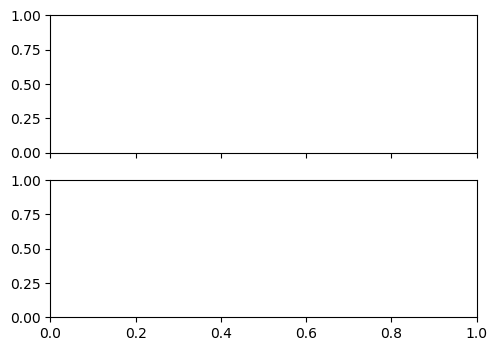

In [119]:
# Plot
fig, ax = plt.subplots(2,1, sharex=True, sharey=True, figsize=(5.5,4), dpi=100)

ax[0].plot(t*omega_orb, (flux1+refl1 + flux2+refl2 + 1.0)*1000, c='C1', lw=1, label=r'$F$(total)')


ax[1].plot(t*omega_orb, (refl1 +refl2 + 1.04)*1000, c='C4', lw=1, label=r'$F$(refls.)')

ax[1].plot(t*omega_orb, (flux2 + 1.02)*1000, c='C3', lw=1, label=r'$F$(Ab)')

ax[1].plot(t*omega_orb, (flux1 + 0.99)*1000, c='C2', lw=1, label=r'$F$(Aa)')

#ax.plot(t*omega_orb, (flux3+refl3 + flux4+refl4 + 1.0)*1000, c='C1', lw=1, label='A')

ax[0].set_xlim(0.5,1.5)
ax[0].set_ylim(0.95*1000,1.05*1000)

legend_style = {'framealpha':1.0, 'handlelength':1.2, 'handletextpad':0.5, 'fontsize':'small'}
ax[0].legend(loc=1, **legend_style)
ax[1].legend(loc=1, **legend_style)

ax[0].set_title(f'$\iota$Ori A flux, BRITE-B, $i$={inc}')

fig.text(0.01, 0.5, r'Relative Flux Perturbation ($\times 1000$)', va='center', rotation='vertical')
fig.text(0.5, 0.01, f"phase (P={1./omega_orb:4.4f} d)", ha='center')

fig.savefig(f'iOri_response-2.png')

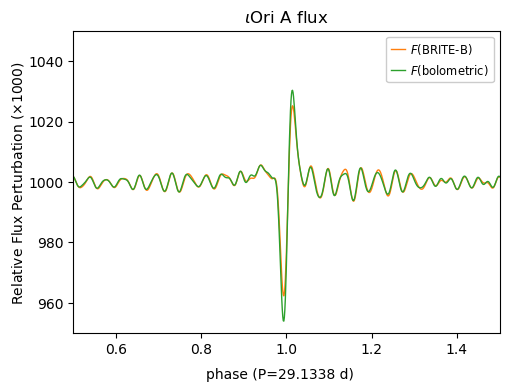

In [87]:
# Plot
fig, ax = plt.subplots(figsize=(5.5,4), dpi=100)

ax.plot(t*omega_orb, (flux1+refl1 + flux2+refl2 + 1.0)*1000, c='C1', lw=1, label=r'$F$(BRITE-B)')

ax.plot(t*omega_orb, (flux3+refl3 + flux4+refl4 + 1.0)*1000, c='C2', lw=1, label=r'$F$(bolometric)')

ax.set_xlim(0.5,1.5)
ax.set_ylim(0.95*1000,1.05*1000)

legend_style = {'framealpha':1.0, 'handlelength':1.2, 'handletextpad':0.5, 'fontsize':'small'}
ax.legend(loc=1, **legend_style)
ax.legend(loc=1, **legend_style)

ax.set_title(f'$\iota$Ori A flux')

fig.text(0.01, 0.5, r'Relative Flux Perturbation ($\times 1000$)', va='center', rotation='vertical')
fig.text(0.5, 0.01, f"phase (P={1./omega_orb:4.4f} d)", ha='center')

fig.savefig(f'iOri_bandpass.png')

### The Case Without Rotation

In [11]:
def read_response(filename):
    
    # Read data from gyre_response
    
    f = h5py.File(filename, 'r')
        
    xi_r_ref_re = f['xi_r']['re'][...]
    xi_r_ref_im = f['xi_r']['im'][...]
        
    lag_L_ref_re = f['lag_L']['re'][...]
    lag_L_ref_im = f['lag_L']['im'][...]
    
    k_max = f.attrs['k_max']
    l_max = f.attrs['l_max']
    
    Omega_rot = f.attrs['Omega_rot']
    Omega_orb = f.attrs['Omega_orb']
    
    f.close()
    
    return {'xi_r_ref': xi_r_ref_re + 1j*xi_r_ref_im,
            'lag_L_ref': lag_L_ref_re + 1j*lag_L_ref_im,
            'k_max': k_max,
            'l_max': l_max,
            'Omega_rot': Omega_rot,
            'Omega_orb': Omega_orb}

In [12]:
def Delta_R(data, i_l,i_m,i_k):

    return np.sqrt(4.*np.pi) * data['xi_r_ref'][i_k,i_m,i_l]
    
    
def Delta_T(data, i_l,i_m,i_k):
        
    xi_r_ref = data['xi_r_ref'][i_k,i_m,i_l]
    
    lag_L_ref = data['lag_L_ref'][i_k,i_m,i_l]
    
    return np.sqrt(4.*np.pi)*(lag_L_ref - 2*xi_r_ref)/4.
  

def Delta_G(data, i_l,i_m,i_k, m,k):
    
    xi_r_ref = data['xi_r_ref'][i_k,i_m,i_l]
    
    omega = -k*data['Omega_orb'] - m*data['Omega_rot']
    
    return np.sqrt(4*np.pi)*(-omega**2 - 2)*xi_r_ref

In [13]:
def R_lm(l,m, phi,theta, I,x):
    
    Rlm = (2 + l)*(1 - l)*I[f'I_{x}_{l}'][:] / I[f'I_{x}_0'][:]
    
    Y = sph_harm(m,l, phi,theta)
    
    return Rlm[0]*Y


def T_lm(l,m, phi,theta, I,dI,x):
    
    Tlm = dI[f'dlnTeff_{x}_{l}'][:] / I[f'I_{x}_0'][:]
    
    Y = sph_harm(m,l, phi,theta)
    
    return Tlm[0]*Y


def G_lm(l,m, phi,theta, I,dI,x):
    
    Glm = dI[f'dlng_{x}_{l}'][:] / I[f'I_{x}_0'][:]
    
    Y = sph_harm(m,l, phi,theta)
    
    return Glm[0]*Y

In [14]:
def eval_fourier (data, I,dI,x, theta_0, phi_0, terms=False):

    # Initialize the frequencies/amplitudes arrays
    f = np.arange(data['k_max']+1)*data['Omega_orb']
    A = np.zeros(data['k_max']+1, dtype=np.complex)
    
    if terms==True:
        A_R = np.zeros(data['k_max']+1, dtype=np.complex)
        A_T = np.zeros(data['k_max']+1, dtype=np.complex)
        A_G = np.zeros(data['k_max']+1, dtype=np.complex)

    # Loop over l, m and k
    
    for l in range(2, data['l_max']+1):
        for m in range(-l, l+1):
            for k in range(0, data['k_max']+1):

                i_l = l
                i_m = m + data['l_max']
                i_k = k

                Del_R = Delta_R(data, i_l,i_m,i_k)
                Del_T = Delta_T(data, i_l,i_m,i_k)
                Del_G = Delta_G(data, i_l,i_m,i_k, m,k)

                Yml = sph_harm(m, l, phi_0, theta_0)

                Rml = (2 + l)*(1 - l)*I[f'I_{x}_{l}'][:] / I[f'I_{x}_0'][:] * Yml
                Tml = dI[f'dlnTeff_{x}_{l}'][:] / I[f'I_{x}_0'][:] * Yml
                Gml = dI[f'dlng_{x}_{l}'][:] / I[f'I_{x}_0'][:] * Yml
                
                if k == 0:
                    if m == 0:
                        kappa = 0.5
                    elif m >= 1:
                        kappa = 1.
                    else:
                        kappa = 0.
                else:
                    kappa = 1.

                # Add the Fourier contribution
                
                A[i_k] += 2*kappa*(Del_R*Rml + Del_T*Tml + Del_G*Gml)
                
                if terms==True:
                    A_R[i_k] += 2*kappa * Del_R*Rml
                    A_T[i_k] += 2*kappa * Del_T*Tml
                    A_G[i_k] += 2*kappa* Del_G*Gml
        
    # Return data
    if terms==True:
        return f, A_R, A_T, A_G
    else:
        return f, A

# iOri , a binary

In [15]:
I = h5py.File('iOri-partials-2.h5','r')
dI = h5py.File('iOri-partials-2.h5','r')

In [16]:
gyre_data = read_response("../gyre_run/response.001.h5")

l_max = gyre_data['l_max']
k_max = gyre_data['k_max']

omega_orb = gyre_data['Omega_orb']

inc = 62.9
omega = 122.2

theta = inc/180 * np.pi
phi = (90-omega)/180 * np.pi

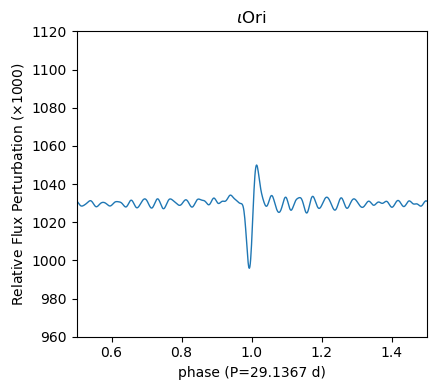

In [18]:
# Evaluate fourier terms
B,R='BRITE-B','BRITE-R'
t = np.linspace(-0.2/omega_orb, 2.2/omega_orb, 2001)

f, A_B = eval_fourier(gyre_data, I,dI,B, theta,phi, terms=False)
#_, A_R = eval_fourier(gyre_data, I,dI,R, theta,phi, terms=False)

# Initialize the frequencies/amplitudes arrays

diff_flux_B = np.zeros_like(t)
#diff_flux_R = np.zeros_like(t)

# Add contributions from each frequency component

n_A = len(A_B)

for i in range(n_A):

    diff_flux_B += np.real(A_B[i] * np.exp(1j*f[i]*2*np.pi*t))
#    diff_flux_R += np.real(A_R[i] * np.exp(1j*f[i]*2*np.pi*t))


fig, ax = plt.subplots( figsize=(4.5,4), dpi=100)


ax.plot(t*omega_orb, (diff_flux_B + 1.03)*1000, c='C0', lw=1, label='BRITE-B')

#ax.plot(t*omega_orb, (diff_flux_R + 1.0)*1000, c='C3', lw=1, label='BRITE-R')

ax.set_ylabel(r'Relative Flux Perturbation ($\times 1000$)')
ax.set_xlabel(f"phase (P={1./gyre_data['Omega_orb']:4.4f} d)")

ax.set_xlim(0.5,1.5)
ax.set_ylim(0.96*1000,1.12*1000)

#ax.legend()

ax.set_title(f'$\iota$Ori')
fig.tight_layout()
fig.savefig(f'iOri_concept.png')

### Synthetic BRITE Lightcurve

In [ ]:
# Evaluate fourier terms
B,R='BRITE-B','BRITE-R'
t = np.linspace(-0.2/omega_orb, 2.2/omega_orb, 1001)

f, A_B = eval_fourier(gyre_data, I,dI,B, theta,phi)
_, A_R = eval_fourier(gyre_data, I,dI,R, theta,phi)

# Initialize the frequencies/amplitudes arrays

diff_flux_B = np.zeros_like(t)
diff_flux_R = np.zeros_like(t)

# Add contributions from each frequency component

n_A = len(A_B)

for i in range(n_A):

    diff_flux_B += np.real(A_B[i] * np.exp(1j*f[i]*2*np.pi*t))
    
    diff_flux_R += np.real(A_R[i] * np.exp(1j*f[i]*2*np.pi*t))


fig, ax = plt.subplots( figsize=(8,4), dpi=300)

ax.plot(t*omega_orb, diff_flux_B + 1.03, c='C0', lw=1, label='BRITE-B')

ax.plot(t*omega_orb, diff_flux_R + 1.0, c='C3', lw=1, label='BRITE-R')

ax.set_ylabel('amplitude')
ax.set_xlabel(f"phase (P={1./gyre_data['Omega_orb']:4.4f} d)")

ax.set_xlim(0.6,1.6)
ax.set_ylim(0.96,1.12)

ax.legend()

ax.set_title(f'$\iota$Ori synthetic lightcurve')
fig.savefig(f'iOri_synBRITE.png')

### Inter-term Cancellation

In [ ]:
# Evaluate fourier terms
B,R='BRITE-B','BRITE-R'
t = np.linspace(-0.2/omega_orb, 2.2/omega_orb, 1001)

f, A_R, A_T,_ = eval_fourier(gyre_data, I,dI,B, theta,phi, terms=True)

# Initialize the frequencies/amplitudes arrays

diff_flux_R = np.zeros_like(t)
diff_flux_T = np.zeros_like(t)

# Add contributions from each frequency component

n_A = len(A_R)

for i in [2]:

    diff_flux_R += np.real(A_R[i] * np.exp(1j*f[i]*2*np.pi*t))
    diff_flux_T += np.real(A_T[i] * np.exp(1j*f[i]*2*np.pi*t))


fig, ax = plt.subplots( figsize=(8,4), dpi=100)

ax.plot(t*omega_orb, diff_flux_R, c='C1', lw=1, label=r'$\mathcal{R}$')

ax.plot(t*omega_orb, diff_flux_T, c='C2', lw=1, label=r'$\mathcal{T}$')

ax.set_ylabel('amplitude')
ax.set_xlabel(f"phase (P={1./gyre_data['Omega_orb']:4.4f} d)")

ax.set_xlim(0.,1.)

ax.legend()

ax.set_title(f'$\iota$Ori U flux terms')
fig.savefig(f'iOri_U_dff_xx{3}.png')

### color-moments

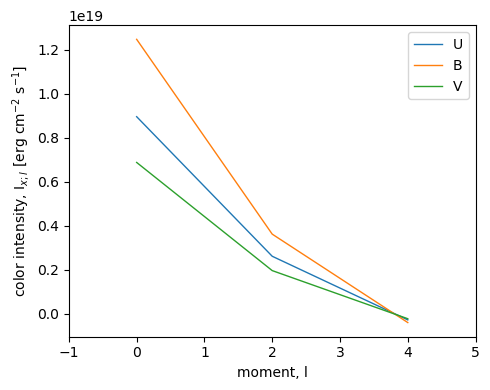

In [33]:
# Plot the results
fig, ax = plt.subplots( figsize=(5,4), dpi=100)

stepsize = 1
lw = 1

ax.plot([i for i in [0,2,4]], [spec[f'I_U_{i}'][:] for i in [0,2,4]]
        , label=r'U' , c='C0', lw=lw)
ax.plot([i for i in [0,2,4]], [spec[f'I_B_{i}'][:] for i in [0,2,4]]
        , label=r'B' , c='C1', lw=lw)
ax.plot([i for i in [0,2,4]], [spec[f'I_V_{i}'][:] for i in [0,2,4]]
        , label=r'V' , c='C2', lw=lw)

ax.set_xlabel(r'moment, l')
ax.set_ylabel(r'color intensity, I$_{x;l}$ [erg cm$^{-2}$ s$^{-1}$]')

ax.set_xlim(-1,5)

ax.legend()

#ax.set_title(r'Rotational Broadening')

fig.tight_layout()
fig.savefig('moment-vs-color-vrot10.png')

In [44]:
if spec.__bool__():
       spec.close()
if spvr.__bool__():
       spvr.close()


<b> Calculate Specific Flux </b>

$F_{\lambda}(d) = 2 \pi \cdot \frac{R_{\star}^2}{d^2} \int_0^1 I_{\lambda}(\mu) d\mu$

$\rightarrow F_{\lambda}= 2 \pi \int_0^1 I_{\lambda}(\mu) d\mu$

## Alnitak

https://arxiv.org/pdf/1306.0330.pdf